**Mount to drive**

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Import Packages**

In [2]:
import numpy as np
import pandas as pd
from scipy.spatial import distance as dist
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from tqdm import tqdm 
from sklearn.utils import shuffle
from sklearn import decomposition
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
import tensorflow as tf
import keras
from keras.applications.vgg16 import VGG16 
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input
from keras.models import Sequential, Model 
from keras.applications.densenet import DenseNet201
from keras.initializers import he_normal
from keras.layers import Lambda, SeparableConv2D, BatchNormalization, Dropout, MaxPooling2D, Input, Dense, Conv2D, Activation, Flatten 
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import imutils

**Object Detection using Edges, Contours, Box**

In [3]:
def findEdges(image):
    # find edges in image
    gray = cv2.GaussianBlur(image, (1, 1), 0)
    edged = cv2.Canny(gray, 100, 400)
    edged = cv2.dilate(edged, None, iterations=1)
    edged = cv2.erode(edged, None, iterations=1)
    return edged

In [4]:
def getImgContours(edged):
    # find contours in the edge map
    contours = cv2.findContours(edged.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours = imutils.grab_contours(contours)
    contours = sorted(contours, key=lambda x: cv2.contourArea(x))
    return contours

In [5]:
def getBoxes(contours, orig):
    # get the boxes
    boxes = []
    centers = []
    for contour in contours:
        box = cv2.minAreaRect(contour)
        box = cv2.cv.BoxPoints(box) if imutils.is_cv2() else cv2.boxPoints(box)
        box = np.array(box, dtype="int")
        (tl, tr, br, bl) = box
        if (dist.euclidean(tl, bl)) > 0 and (dist.euclidean(tl, tr)) > 0:
            boxes.append(box)
    return boxes

**Loading the Data**

In [6]:
class_names = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']
nb_classes = len(class_names)
image_size = (120,120)

In [7]:
def load_data():

    datasets = ['/content/drive/MyDrive/Colab Notebooks/Blood Cell Detection/dataset/dataset2-master/images/TRAIN',
                '/content/drive/MyDrive/Colab Notebooks/Blood Cell Detection/dataset/dataset2-master/images/TEST' ]
    images = []
    labels = []

    # iterate through training and test sets
    count =0
    for dataset in datasets:

        # iterate through folders in each dataset
        for folder in os.listdir(dataset):

            if folder in ['EOSINOPHIL']: label = 0
            elif folder in ['LYMPHOCYTE']: label = 1
            elif folder in ['MONOCYTE']: label = 2
            elif folder in ['NEUTROPHIL']: label = 3

            # iterate through each image in folder
            for file in tqdm(os.listdir(os.path.join(dataset, folder))):

                # get pathname of each image
                img_path = os.path.join(os.path.join(dataset, folder), file)

                # Open 
                image = cv2.imread(img_path)
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                
                # add padding to the image to better detect cell at the edge
                image = cv2.copyMakeBorder(image,10,10,10,10,cv2.BORDER_CONSTANT,value=[198, 203, 208])
                
                #thresholding the image to get the target cell
                image1 = cv2.inRange(image,(80, 80, 180),(180, 170, 245))
                
                # openning errosion then dilation
                kernel = np.ones((3, 3), np.uint8)
                kernel1 = np.ones((5, 5), np.uint8)
                img_erosion = cv2.erode(image1, kernel, iterations=2)
                image1 = cv2.dilate(img_erosion, kernel1, iterations=5)
                
                #detecting the blood cell
                edgedImage = findEdges(image1)
                edgedContours = getImgContours(edgedImage)
                edgedBoxes =  getBoxes(edgedContours, image.copy())
                if len(edgedBoxes)==0:
                    count +=1
                    continue
                # get the large box and get its cordinate
                last = edgedBoxes[-1]
                max_x = int(max(last[:,0]))
                min_x = int( min(last[:,0]))
                max_y = int(max(last[:,1]))
                min_y = int(min(last[:,1]))
                
                # draw the contour and fill it 
                mask = np.zeros_like(image)
                cv2.drawContours(mask, edgedContours, len(edgedContours)-1, (255,255,255), -1) 
                
                # any pixel but the pixels inside the contour is zero
                image[mask==0] = 0
                
                # extract th blood cell
                image = image[min_y:max_y, min_x:max_x]

                if (np.size(image)==0):
                    count +=1
                    continue
                # resize th image
                image = cv2.resize(image, image_size)

                # Append the image and its corresponding label to the output
                images.append(image)
                labels.append(label)

    images = np.array(images, dtype = 'float32')
    labels = np.array(labels, dtype = 'int32')

    return images, labels


In [8]:
images, labels = load_data()

100%|██████████| 624/624 [04:32<00:00,  2.29it/s]


**Spliting the data in Train(80%),validation(10%) and Test(10%)**

In [9]:
images, labels = shuffle(images, labels, random_state=10)

train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size = 0.2)
test_images, val_images, test_labels, val_labels = train_test_split(test_images, test_labels, test_size = 0.5)

In [10]:
n_train = train_labels.shape[0]
n_val = val_labels.shape[0]
n_test = test_labels.shape[0]

print("Number of training examples: {}".format(n_train))
print("Number of validation examples: {}".format(n_val))
print("Number of testing examples: {}".format(n_test))

print("Training images are of shape: {}".format(train_images.shape))
print("Training labels are of shape: {}".format(train_labels.shape))
print("Validation images are of shape: {}".format(val_images.shape))
print("Validation labels are of shape: {}".format(val_labels.shape))
print("Test images are of shape: {}".format(test_images.shape))
print("Test labels are of shape: {}".format(test_labels.shape))


Number of training examples: 9716
Number of validation examples: 1215
Number of testing examples: 1215
Training images are of shape: (9716, 120, 120, 3)
Training labels are of shape: (9716,)
Validation images are of shape: (1215, 120, 120, 3)
Validation labels are of shape: (1215,)
Test images are of shape: (1215, 120, 120, 3)
Test labels are of shape: (1215,)


**Exploratory Data Analysis**

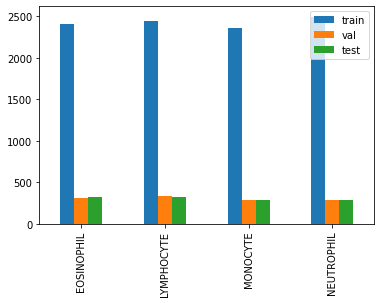

In [11]:
_, train_counts = np.unique(train_labels, return_counts = True)
_, val_counts = np.unique(val_labels, return_counts = True)
_, test_counts = np.unique(test_labels, return_counts = True)

pd.DataFrame({'train': train_counts, "val": val_counts, "test": test_counts}, index = class_names).plot.bar()

plt.show()

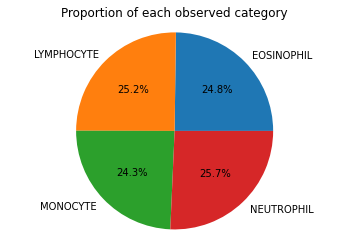

In [12]:
plt.pie(train_counts,
        explode=(0, 0, 0, 0) , 
        labels=class_names,
        autopct='%1.1f%%')
plt.axis('equal')
plt.title('Proportion of each observed category')
plt.show()

In [13]:
# increase computational speed by making pixels between 0-1
train_images = train_images / 255.0 
val_images = val_images / 255.0
test_images = test_images / 255.0

9716


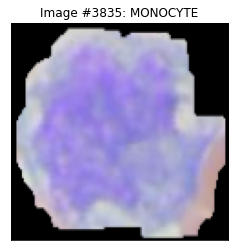

In [14]:
def display_random_image (class_names, images, labels):
    print(len(images))
    index = np.random.randint(images.shape[0])
    plt.figure()
    plt.imshow(images[index])
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title('Image #{}: '.format(index) + class_names[labels[index]])
    plt.show()
    
display_random_image (class_names, train_images, train_labels)

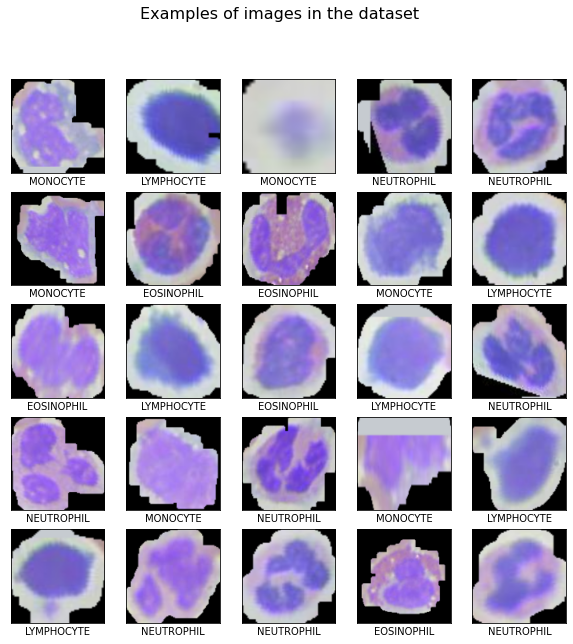

In [15]:
def display_examples(class_names, images, labels):
    fig = plt.figure(figsize = (10,10))
    fig.suptitle("Examples of images in the dataset", fontsize=16)
    for i in range(25):
        plt.subplot(5,5,i+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(images[i], cmap=plt.cm.binary)
        plt.xlabel(class_names[labels[i]])
    plt.show()
    
display_examples(class_names, train_images, train_labels)

**CNN**

In [16]:

model1 = Sequential()

# First Conv block
model1.add(Conv2D(16 , (3,3) , padding = 'same' , activation = 'relu' , input_shape = (120,120,3)))
model1.add(Conv2D(16 , (3,3), padding = 'same' , activation = 'relu'))
model1.add(MaxPooling2D(pool_size = (2,2)))

# Second Conv block
model1.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(32, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

# Third Conv block
model1.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(64, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))

# Forth Conv block
model1.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(128, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))

# Fifth Conv block 
model1.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(SeparableConv2D(256, (3,3), activation = 'relu', padding = 'same'))
model1.add(BatchNormalization())
model1.add(MaxPooling2D(pool_size = (2,2)))
model1.add(Dropout(0.2))


# FC layer 
model1.add(Flatten())
model1.add(Dense(units = 512 , activation = 'tanh'))
model1.add(Dropout(0.7))
model1.add(Dense(units = 128 , activation = 'tanh'))
model1.add(Dropout(0.5))
model1.add(Dense(units = 64 , activation = 'tanh'))
model1.add(Dropout(0.3))

# Output layer
model1.add(Dense(units = 4 , activation = 'softmax'))

# Compile
model1.compile(optimizer = "adam" , loss = 'sparse_categorical_crossentropy' , metrics = ['accuracy'])
model1.summary()

# Implement callbacks 
checkpoint = ModelCheckpoint(filepath='best_model.hdf5', save_best_only=True, save_weights_only=False)
early_stop = EarlyStopping(monitor='val_loss', min_delta=0.1, patience=3, verbose = 1, mode='min', restore_best_weights = True)
learning_rate_reduction = ReduceLROnPlateau(
    monitor = 'val_accuracy', 
    patience = 2, 
    verbose = 1, 
    factor = 0.3, 
    min_lr = 0.000001)

# Train
history1 = model1.fit(
    train_images, 
    train_labels, 
    batch_size = 32, 
    epochs = 30, 
    validation_data=(val_images, val_labels), 
    callbacks=[learning_rate_reduction])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 120, 120, 16)      448       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 120, 120, 16)      2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 60, 60, 16)        0         
_________________________________________________________________
separable_conv2d (SeparableC (None, 60, 60, 32)        688       
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 60, 60, 32)        1344      
_________________________________________________________________
batch_normalization (BatchNo (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0

In [17]:
def plot_accuracy_loss_chart(history):
    epochs = [i for i in range(30)]
    fig , ax = plt.subplots(1,2)
    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    val_acc = history.history['val_accuracy']
    val_loss = history.history['val_loss']
    fig.set_size_inches(20,10)
    ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
    ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
    ax[0].set_title('Training & Validation Accuracy')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")

    ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
    ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
    ax[1].set_title('Training & Validation Loss')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Training & Validation Loss")
    plt.show()

In [18]:
results = model1.evaluate(test_images, test_labels)

print("Loss of the model  is - test ", results[0])
print("Accuracy of the model is - test", results[1]*100, "%")


results = model1.evaluate(val_images, val_labels)

print("Loss of the model  is - val ", results[0])
print("Accuracy of the model is - val", results[1]*100, "%")

results = model1.evaluate(train_images, train_labels)

print("Loss of the model  is - train ", results[0])
print("Accuracy of the model is - train", results[1]*100, "%")

38/38 [==============================] - 6s 162ms/step - loss: 0.0637 - accuracy: 0.9802
Loss of the model  is - test  0.06374361366033554
Accuracy of the model is - test 98.0246901512146 %
38/38 [==============================] - 6s 162ms/step - loss: 0.0477 - accuracy: 0.9827
Loss of the model  is - val  0.04774954915046692
Accuracy of the model is - val 98.27160239219666 %
304/304 [==============================] - 49s 161ms/step - loss: 0.0166 - accuracy: 0.9958
Loss of the model  is - train  0.01660429686307907
Accuracy of the model is - train 99.57801699638367 %


In [25]:
model1.save('/content/drive/MyDrive/Colab Notebooks/Blood Cell Detection/Bloodcell_Classification_Model1_Custom_Build_10_epochs.h5')

In [26]:
from sklearn.metrics import classification_report

predictions = model1.predict(test_images)
predictions = np.argmax(predictions,axis=1)
predictions[:15]

array([0, 0, 3, 0, 0, 1, 2, 2, 3, 1, 3, 0, 1, 1, 1])

In [21]:
print(classification_report(
    test_labels, 
    predictions, 
    target_names = ['EOSINOPHIL (Class 0)', 'LYMPHOCYTE (Class 1)', 'MONOCYTE (Class 2)', 'NEUTROPHIL (Class 3)']))

                      precision    recall  f1-score   support

EOSINOPHIL (Class 0)       0.97      0.97      0.97       323
LYMPHOCYTE (Class 1)       1.00      1.00      1.00       325
  MONOCYTE (Class 2)       1.00      1.00      1.00       285
NEUTROPHIL (Class 3)       0.96      0.96      0.96       282

            accuracy                           0.98      1215
           macro avg       0.98      0.98      0.98      1215
        weighted avg       0.98      0.98      0.98      1215



In [22]:
cm = confusion_matrix(test_labels, predictions)
cm = pd.DataFrame(cm, index = ['0', '1', '2', '3'], columns = ['0', '1', '2', '3'])
cm

,0,1,2,3
0,312,0,1,10
1,0,325,0,0
2,0,0,284,1
3,11,1,0,270


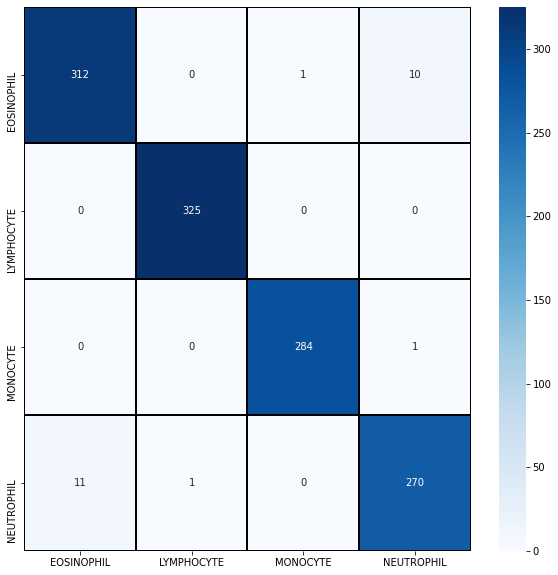

In [23]:
def plot_confusion_matrix (cm):
    plt.figure(figsize = (10,10))
    sns.heatmap(
        cm, 
        cmap = 'Blues', 
        linecolor = 'black', 
        linewidth = 1, 
        annot = True, 
        fmt = '', 
        xticklabels = class_names, 
        yticklabels = class_names)
    
plot_confusion_matrix(cm)

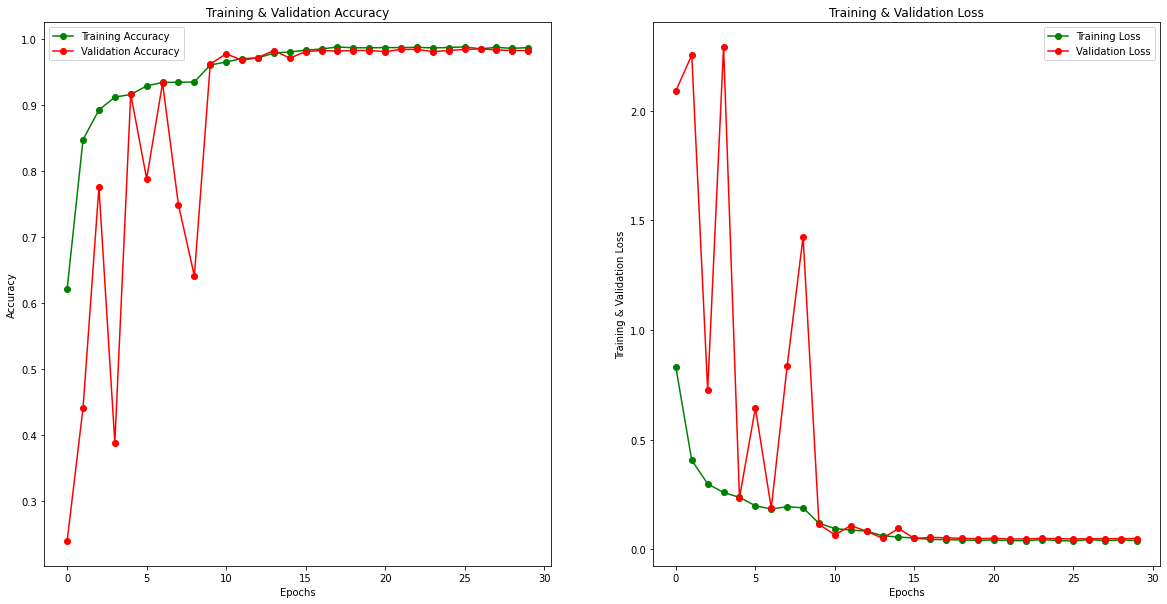

In [24]:
plot_accuracy_loss_chart(history1)